## Regression with Categorical Outcome Variable: NBA Data Set

In [129]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, classification_report

In [130]:
# from IPython.display import display, HTML

# display(HTML(data="""
# <style>
#     div#notebook-container    { width: 95%; }
#     div#menubar-container     { width: 65%; }
#     div#maintoolbar-container { width: 99%; }
# </style>
# """))

In [131]:
#Import Data
NBA = pd.read_csv("Assignment Data/NBA_Games2.csv")
NBA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18414 entries, 0 to 18413
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CITY               18414 non-null  object 
 1   TEAM_NAME          18414 non-null  object 
 2   TEAM_ID            18414 non-null  int64  
 3   NICKNAME           18414 non-null  object 
 4   STATE              18414 non-null  object 
 5   YEAR_FOUNDED       18414 non-null  int64  
 6   SEASON_ID          18414 non-null  int64  
 7   TEAM_ABBREVIATION  18414 non-null  object 
 8   GAME_ID            18414 non-null  int64  
 9   GAME_DATE          18414 non-null  object 
 10  MATCHUP            18414 non-null  object 
 11  WL                 18414 non-null  object 
 12  MIN                18414 non-null  int64  
 13  PTS                18414 non-null  int64  
 14  FGM                18414 non-null  int64  
 15  FGA                18414 non-null  int64  
 16  FG_PCT             184

In [132]:
# Step 1 Bulding the Dataset - NBA Data Set
# 1.1
nba_2017 = (NBA[['GAME_ID', 'MATCHUP', 'PTS', 'PLUS_MINUS', 'WIN', 'TEAM_ABBREVIATION','SEASON_ID','GAME_DATE']].copy()
               .rename({'TEAM_ABBREVIATION':'TEAM'}, axis=1))
nba_2017 = nba_2017[(nba_2017.SEASON_ID==22017) & (nba_2017.GAME_ID<1000000000)]

# 1.2
# Not sure what this step means

# 1.3
# done

# 1.4
# Filter 2017 regular season records
recs_2017 = nba_2017.groupby('TEAM').agg({'WIN':['sum','count']}).reset_index()
recs_2017.columns = ['TEAM','W','L']
recs_2017['L'] = recs_2017['L'] - recs_2017['W']
recs_2017

# Generate home dummy variable
nba_2017['HOME'] = np.where(nba_2017['MATCHUP'].str.contains(r'@', regex=False), 0, 1)
nba_2017

# Get game scores
# game_scores = nba_2017.groupby(['GAME_ID','TEAM'])['PTS'].sum().reset_index()
# game_scores = game_scores.merge(game_scores.groupby('GAME_ID').sum().reset_index().rename({'PTS':'PTSa'},axis=1), on='GAME_ID')
# game_scores['PTSa'] = game_scores['PTSa'] - game_scores['PTS']
# nba_2017 = nba_2017.merge(game_scores.drop('PTS',axis=1), on=['GAME_ID','TEAM'])
nba_2017['PTSa'] = (nba_2017['PTS'] - nba_2017['PLUS_MINUS']).astype(int)

# Sort by data
nba_2017['GAME_DATE'] = pd.to_datetime(nba_2017['GAME_DATE'])
nba_2017 = nba_2017.sort_values('GAME_DATE')

# Add pythagorean win %
nba_2017['cumPTS'] = nba_2017.groupby('TEAM')['PTS'].cumsum()
nba_2017['cumPTSa'] = nba_2017.groupby('TEAM')['PTSa'].cumsum()

nba_2017['pyth_wpct'] = nba_2017['cumPTS']**2 / (nba_2017['cumPTS']**2 + nba_2017['cumPTSa']**2)
nba_2017

,GAME_ID,MATCHUP,PTS,PLUS_MINUS,WIN,TEAM,SEASON_ID,GAME_DATE,HOME,PTSa,cumPTS,cumPTSa,pyth_wpct
1501,21700001,CLE vs. BOS,102,3.0,1,CLE,22017,2017-10-17,1,99,102,99,0.514922
4630,21700002,GSW vs. HOU,121,-1.0,0,GSW,22017,2017-10-17,1,122,121,122,0.495885
5328,21700002,HOU @ GSW,122,1.0,1,HOU,22017,2017-10-17,0,121,122,121,0.504115
846,21700001,BOS @ CLE,99,-3.0,0,BOS,22017,2017-10-17,0,102,99,102,0.485078
8731,21700004,BKN @ IND,131,-9.0,0,BKN,22017,2017-10-18,0,140,131,140,0.466826
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12952,21701230,SAC vs. HOU,96,13.0,1,SAC,22017,2018-04-11,1,83,8104,8676,0.465951
16172,21701227,MEM @ OKC,123,-14.0,0,MEM,22017,2018-04-11,0,137,8145,8654,0.469728
2646,21701224,CHI vs. DET,87,-32.0,0,CHI,22017,2018-04-11,1,119,8440,9017,0.466983
17441,21701224,DET @ CHI,119,32.0,1,DET,22017,2018-04-11,0,87,8509,8519,0.499413


In [133]:
nba_2017.sort_values('pyth_wpct', ascending=False)

,GAME_ID,MATCHUP,PTS,PLUS_MINUS,WIN,TEAM,SEASON_ID,GAME_DATE,HOME,PTSa,cumPTS,cumPTSa,pyth_wpct
12403,21700012,POR @ PHX,124,48.0,1,POR,22017,2017-10-18,0,76,124,76,0.726929
12402,21700018,POR @ IND,114,18.0,1,POR,22017,2017-10-20,0,96,238,172,0.656910
14986,21700027,TOR vs. PHI,128,34.0,1,TOR,22017,2017-10-21,1,94,245,194,0.614626
14317,21700015,OKC vs. NYK,105,21.0,1,OKC,22017,2017-10-19,1,84,105,84,0.609756
12401,21700034,POR @ MIL,110,2.0,0,POR,22017,2017-10-21,0,108,348,280,0.607025
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11788,21700048,PHX vs. SAC,117,2.0,1,PHX,22017,2017-10-23,1,115,411,501,0.402268
11790,21700026,PHX vs. LAL,130,-2.0,0,PHX,22017,2017-10-20,1,132,206,256,0.393028
9343,21700015,NYK @ OKC,84,-21.0,0,NYK,22017,2017-10-19,0,105,84,105,0.390244
11789,21700037,PHX @ LAC,88,-42.0,0,PHX,22017,2017-10-21,0,130,294,386,0.367138


In [134]:
# Step 2 Running Regression - Part I
# 2.1
lpm_model = smf.ols('WIN ~ pyth_wpct', data=nba_2017)
lpm_result= lpm_model.fit()
lpm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    WIN   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     268.8
Date:                Thu, 30 Dec 2021   Prob (F-statistic):           2.63e-57
Time:                        21:36:02   Log-Likelihood:                -1598.5
No. Observations:                2378   AIC:                             3201.
Df Residuals:                    2376   BIC:                             3213.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6461      0.192    -13.773      0.000      -3.023      -2.269
pyth_wpct      6.2945      0.384     16.394      0.000       5.542       7.047
==============================================================================
Omnibus:                    11609.632   Durbin-Watson:                   2.168
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              266.245
Skew:                           0.001   Prob(JB):                     1.53e-58
Kurtosis:                       1.361   Cond. No.                         49.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

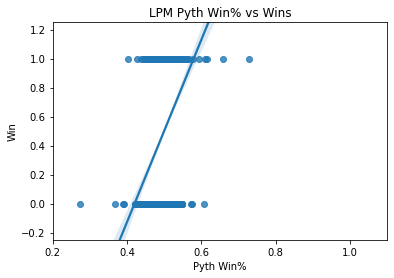

In [135]:
# 2.2
sns.regplot(x='pyth_wpct', y='WIN', data=nba_2017)
plt.xlabel('Pyth Win%')
plt.ylabel('Win')
plt.title('LPM Pyth Win% vs Wins')
plt.xlim((0.2,1.1))
plt.ylim((-0.25,1.25))
plt.show()

In [136]:
# 2.3 & 2.4
lr_model = smf.glm('WIN ~ pyth_wpct', data=nba_2017, family=sm.families.Binomial())
lr_result = lr_model.fit()
lr_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    WIN   No. Observations:                 2378
Model:                            GLM   Df Residuals:                     2376
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1513.6
Date:                Thu, 30 Dec 2021   Deviance:                       3027.3
Time:                        21:36:02   Pearson chi2:                 2.41e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1071
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -15.2821      1.027    -14.877      0.000     -17.295     -13.269
pyth_wpct     30.5728      2.053     14.892      0.000      26.549      34.597
==============================================================================
"""

In [137]:
# 2.5
lr_predict = lr_result.predict()
lr_predict

# Make binary
lr_win = lr_predict.round().astype(int)

In [138]:
# 2.6
print(confusion_matrix(nba_2017['WIN'], lr_win))
print(classification_report(nba_2017['WIN'], lr_win, digits=4))

[[743 447]
 [389 799]]
              precision    recall  f1-score   support

           0     0.6564    0.6244    0.6400      1190
           1     0.6413    0.6726    0.6565      1188

    accuracy                         0.6484      2378
   macro avg     0.6488    0.6485    0.6482      2378
weighted avg     0.6488    0.6484    0.6482      2378



In [139]:
# 2.7
lr_home_model = smf.glm('WIN ~ pyth_wpct + HOME', data=nba_2017, family=sm.families.Binomial())
lr_home_result= lr_home_model.fit()
lr_home_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    WIN   No. Observations:                 2378
Model:                            GLM   Df Residuals:                     2375
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1481.6
Date:                Thu, 30 Dec 2021   Deviance:                       2963.2
Time:                        21:36:02   Pearson chi2:                 2.41e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1308
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -15.9046      1.049    -15.160      0.000     -17.961     -13.848
pyth_wpct     31.1176      2.088     14.906      0.000      27.026      35.209
HOME           0.7005      0.088      7.931      0.000       0.527       0.874
==============================================================================
"""

In [140]:
# 2.8
lr_home_predict = lr_home_result.predict()
lr_home_win = lr_home_predict.round().astype(int)

# 2.9
print(confusion_matrix(nba_2017['WIN'], lr_home_win))
print(classification_report(nba_2017['WIN'], lr_home_win, digits=4))

[[787 403]
 [423 765]]
              precision    recall  f1-score   support

           0     0.6504    0.6613    0.6558      1190
           1     0.6550    0.6439    0.6494      1188

    accuracy                         0.6526      2378
   macro avg     0.6527    0.6526    0.6526      2378
weighted avg     0.6527    0.6526    0.6526      2378



In [168]:
# Step 3: Basics of Forecasting - Part II
# 3.8
half1 = nba_2017[nba_2017['GAME_ID']<=21700615].copy()
half2 = nba_2017[nba_2017['GAME_ID']>21700615].copy()

nba_2017_pre = (half1.groupby('TEAM').agg(WIN=('WIN','sum'),
                                          GAMES=('WIN','count'),
                                          PTS=('PTS','sum'),
                                          PTSa=('PTSa','sum'))
                                     .reset_index())
nba_2017_pre['win_pct_pre'] = nba_2017_pre['WIN'] / nba_2017_pre['GAMES']
nba_2017_pre['pyth_win_pct_pre'] = nba_2017_pre['PTS']**2 / (nba_2017_pre['PTS']**2 + nba_2017_pre['PTSa']**2)
nba_2017_pre = nba_2017_pre.drop(['WIN','GAMES','PTS','PTSa'], axis=1)

# # Correlation
# lpm_pre = smf.ols('win_pct_pre ~ pyth_win_pct_pre', data=nba_2017_pre).fit()
# display(lpm_pre.summary())

In [170]:
nba_2017_pre.corr()

,win_pct_pre,pyth_win_pct_pre
win_pct_pre,1.000000,0.911661
pyth_win_pct_pre,0.911661,1.000000


In [171]:
# 3.9
nba_2017_post = (half2.groupby('TEAM').agg(WIN=('WIN','sum'),
                                           GAMES=('WIN','count'),
                                           PTS=('PTS','sum'),
                                           PTSa=('PTSa','sum'))
                                      .reset_index())
nba_2017_post['win_pct_post'] = nba_2017_post['WIN'] / nba_2017_post['GAMES']
nba_2017_post['pyth_win_pct_post'] = nba_2017_post['PTS']**2 / (nba_2017_post['PTS']**2 + nba_2017_post['PTSa']**2)
nba_2017_post = nba_2017_post.drop(['WIN','GAMES','PTS','PTSa'], axis=1)

# Combine pre and post
nba_compare = nba_2017_pre.merge(nba_2017_post, on='TEAM')

In [172]:
nba_2017_post

,TEAM,win_pct_post,pyth_win_pct_post
0,ATL,0.317073,0.469537
1,BKN,0.317073,0.479850
2,BOS,0.552632,0.507943
3,CHA,0.488372,0.506220
4,CHI,0.300000,0.462774
5,CLE,0.585366,0.503721
6,DAL,0.230769,0.479219
7,DEN,0.609756,0.508293
8,DET,0.404762,0.494825
9,GSW,0.625000,0.512071


In [164]:
# 3.10
lpm_post_pyth = smf.ols('win_pct_post ~ pyth_win_pct_pre', data=nba_compare).fit()
lpm_post_pre  = smf.ols('win_pct_post ~ win_pct_pre + pyth_win_pct_pre', data=nba_compare).fit()
display(lpm_post_pyth.summary())
display(lpm_post_pre.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           win_pct_post   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     23.84
Date:                Thu, 30 Dec 2021   Prob (F-statistic):           4.17e-05
Time:                        21:49:25   Log-Likelihood:                 17.062
No. Observations:                  29   AIC:                            -30.12
Df Residuals:                      27   BIC:                            -27.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.6285      0.641     -4.103      0.000      -3.943      -1.314
pyth_win_pct_pre     6.2528      1.281      4.883      0.000       3.625       8.880
==============================================================================
Omnibus:                        1.074   Durbin-Watson:                   2.694
Prob(Omnibus):                  0.585   Jarque-Bera (JB):                0.900
Skew:                           0.166   Prob(JB):                        0.638
Kurtosis:                       2.203   Cond. No.                         61.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           win_pct_post   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     11.61
Date:                Thu, 30 Dec 2021   Prob (F-statistic):           0.000250
Time:                        21:49:25   Log-Likelihood:                 17.138
No. Observations:                  29   AIC:                            -28.28
Df Residuals:                      26   BIC:                            -24.17
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.0818      1.388     -2.220      0.035      -5.935      -0.229
win_pct_pre         -0.1608      0.435     -0.370      0.715      -1.055       0.733
pyth_win_pct_pre     7.3204      3.167      2.311      0.029       0.810      13.831
==============================================================================
Omnibus:                        1.183   Durbin-Watson:                   2.689
Prob(Omnibus):                  0.554   Jarque-Bera (JB):                0.900
Skew:                           0.099   Prob(JB):                        0.638
Kurtosis:                       2.160   Cond. No.                         162.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [143]:
## Quiz
# Q1
# Pyth%: 5.542 WRONG  6.2946

# Q2
# 0.102 CORRECT

# Q3
# 26.550 WRONG 30.5739

# Q4
# 2.053 CORRECT

# Q5
# 55% WRONG 65%

# Q6
# 58% WRONG 65%

In [159]:
print((half1['TEAM']=='ATL').value_counts())
print((half1['TEAM']=='CHI').value_counts())
half1

False    1149
True       41
Name: TEAM, dtype: int64
False    1148
True       42
Name: TEAM, dtype: int64


,GAME_ID,MATCHUP,PTS,PLUS_MINUS,WIN,TEAM,SEASON_ID,GAME_DATE,HOME,PTSa,cumPTS,cumPTSa,pyth_wpct
1501,21700001,CLE vs. BOS,102,3.0,1,CLE,22017,2017-10-17,1,99,102,99,0.514922
4630,21700002,GSW vs. HOU,121,-1.0,0,GSW,22017,2017-10-17,1,122,121,122,0.495885
5328,21700002,HOU @ GSW,122,1.0,1,HOU,22017,2017-10-17,0,121,122,121,0.504115
846,21700001,BOS @ CLE,99,-3.0,0,BOS,22017,2017-10-17,0,102,99,102,0.485078
8731,21700004,BKN @ IND,131,-9.0,0,BKN,22017,2017-10-18,0,140,131,140,0.466826
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8092,21700611,MIN vs. OKC,104,16.0,1,MIN,22017,2018-01-10,1,88,4658,4507,0.516471
803,21700614,BOS @ PHI,114,11.0,1,BOS,22017,2018-01-11,0,103,4532,4299,0.526366
1461,21700615,CLE @ TOR,99,-34.0,0,CLE,22017,2018-01-11,0,133,4506,4460,0.505130
11151,21700614,PHI vs. BOS,103,-11.0,0,PHI,22017,2018-01-11,1,114,4228,4214,0.501658


In [ ]:
## Quiz
# Q1
# ATL: 41, CHI: 42 CORRECT

# Q2
# 0.78 WRONG
# 0.89 WRONG

# Q3
# 30% CORRECT

# Q4
# Pyth: 7.55, Win: 0.625 WRONG
# 6.25, 0.756 CORRECT

In [162]:
nba_2017_post

,TEAM,win_pct_post,pyth_win_pct_post
0,ATL,0.317073,0.469537
1,BKN,0.317073,0.479850
2,BOS,0.552632,0.507943
3,CHA,0.488372,0.506220
4,CHI,0.300000,0.462774
5,CLE,0.585366,0.503721
6,DAL,0.230769,0.479219
7,DEN,0.609756,0.508293
8,DET,0.404762,0.494825
9,GSW,0.625000,0.512071
